<a href="https://colab.research.google.com/github/alegarbed/DeepLearning/blob/master/RNN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construcción de una RNN usando Keras

En primer lugar, vamos a añadir todas las librerias necesarias para este proceso.

In [0]:
%%capture

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU 
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image

!pip install livelossplot
from livelossplot.keras import PlotLossesCallback

Para este caso vamos a utilizar el dataset MNIST que contiene 70000 imagenes de números escritos a mano.  El tamaño de las imagenes es de 28x28 pixeles.

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Como podemos apreciar el tamaño del train son 60000 imagenes y el test 10000 imagenes.

In [3]:
print('Train shape:\t', X_train.shape)
print('Test shape:\t', X_test.shape)

Train shape:	 (60000, 28, 28)
Test shape:	 (10000, 28, 28)


Los pixeles estan codificados con un valor entre 0 y 255 siendo este la intensidad maxima del pixel.

In [4]:
np.max([X_train[i] for i in range (X_train.shape[0])])

255

Veamos la representación de alguna imagen.

2


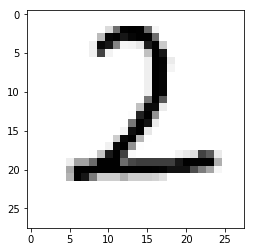

In [5]:
image_index = 7473
print(y_train[image_index]) 
plt.imshow(X_train[image_index], cmap='Greys')

Dado que nuestro objetivo es predecir el valor de la imagen, el número de clases de la variable objetivo será 10. Es decir, los valores de los números (0,...,9).

## Preparación del dataset

In [0]:
n_classes = 10
img_rows, img_cols = 28, 28

In [7]:
X_train.dtype

dtype('uint8')

In [0]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

Se ha trasformado las matrices al formato float32 y se ha normalizado las matrices para que el valor máximo del pixel sea 1.

In [9]:
np.max([X_train[i] for i in range (X_train.shape[0])])

1.0

Ahora, necesitamos que la variable objetivo esté codificada.

In [0]:
# One-hot encoding:
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test  = np_utils.to_categorical(y_test,  n_classes)

In [11]:
print(y_train[4],'\n',Y_train[4])

9 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Construcción de Recurrent Neural Network (RNN)

### Estructura

In [0]:
n_neurons = 100 #Número de neuronas que vamos a utilizar

model = Sequential()

model.add(SimpleRNN(n_neurons,
                    input_shape=(img_rows, img_cols)))

model.add(Dense(units=n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

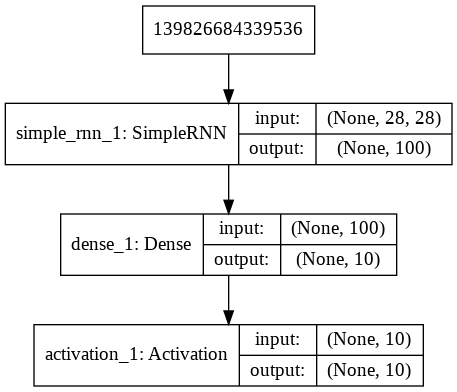

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

### Entrenamiento

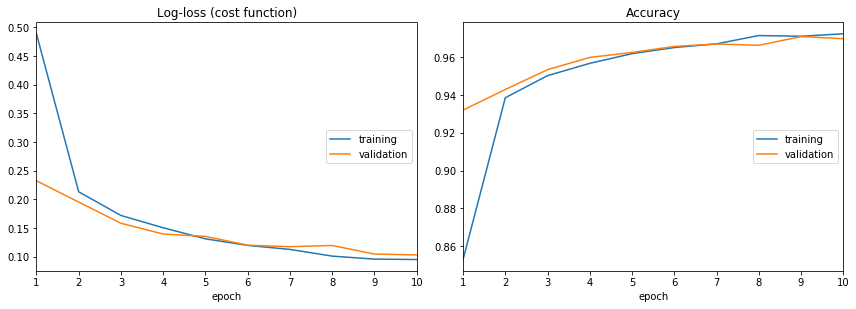

Log-loss (cost function):
training   (min:    0.095, max:    0.489, cur:    0.095)
validation (min:    0.103, max:    0.233, cur:    0.103)

Accuracy:
training   (min:    0.853, max:    0.972, cur:    0.972)
validation (min:    0.932, max:    0.971, cur:    0.970)
CPU times: user 1min 56s, sys: 12.6 s, total: 2min 9s
Wall time: 1min 25s


In [14]:
%%time

epochs = 10
batch  = 128

model.fit(X_train, 
          Y_train, 
          epochs=epochs, 
          batch_size=batch,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesCallback()],
          verbose=1)

### Fallos de clasificación
Se crea una función que nos permite ver cuales han sido los fallos de clasificación.

In [0]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Se muestran los ', maxtoshow, 'primeros fallos. '
          'Clase predicha (Clase Real).')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(X_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Se muestran los  10 primeros fallos. Clase predicha (Clase Real).


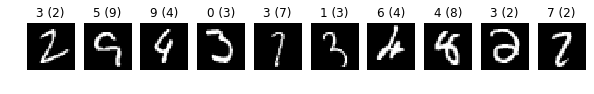

In [16]:
predictions = model.predict(X_test)

show_failures(predictions)

Se muestran los  10 primeros fallos. Clase predicha (Clase Real).


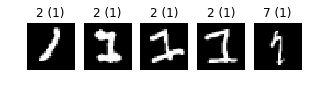

In [17]:
show_failures(predictions, trueclass=1)

## Construcción de otra RNN

In [0]:
n_neurons = 100 #Número de neuronas que vamos a utilizar

model2 = Sequential()

model2.add(SimpleRNN(n_neurons,
                    input_shape=(img_rows, img_cols),
                    return_sequences=True))

model2.add(SimpleRNN(32))

model2.add(Dense(units=n_classes))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

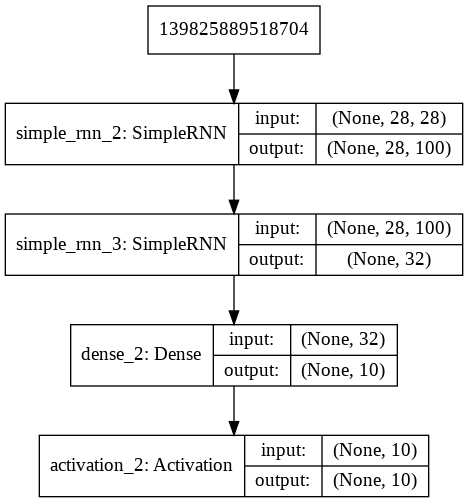

In [19]:
plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model2.png')
Image(filename='model2.png')

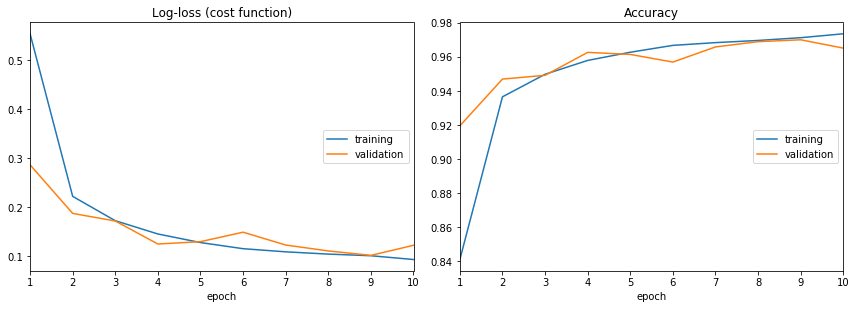

Log-loss (cost function):
training   (min:    0.093, max:    0.554, cur:    0.093)
validation (min:    0.101, max:    0.286, cur:    0.122)

Accuracy:
training   (min:    0.841, max:    0.974, cur:    0.974)
validation (min:    0.919, max:    0.970, cur:    0.965)
CPU times: user 3min 36s, sys: 19.6 s, total: 3min 56s
Wall time: 2min 35s


In [20]:
%%time

epochs = 10
batch  = 128

model2.fit(X_train, 
           Y_train, 
           epochs=epochs, 
           batch_size=batch,
           validation_data=(X_test, Y_test),
           callbacks=[PlotLossesCallback()],
           verbose=1)